In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
np.random.seed(7)
import matplotlib.pyplot as plt
import os

In [36]:
TIMESERIES = "data/timeseries.csv"
SUBMISSIONS = "submissions"

In [3]:
df = pd.read_csv(TIMESERIES, parse_dates=['Date', 'DateIdx'])

In [4]:
len(df)

35040

In [5]:
sum(df.DateIdx == df.Date)

35040

In [6]:
cols = df.columns

In [7]:
cols

Index([u'DateIdx', u'Date', u'VAR', u'dewpti', u'hum', u'pressurei', u'rain',
       u'tempi', u'thunder', u'Day', u'Holiday', u'PCA_1'],
      dtype='object')

In [8]:
df = df[cols[1:]]

In [9]:
df.head()

,Date,VAR,dewpti,hum,pressurei,rain,tempi,thunder,Day,Holiday,PCA_1
0,2016-05-01 00:00:00,24.25751,62.30,82.000000,29.960000,0.0,67.500000,0.0,1,0,-15.419709
1,2016-05-01 00:15:00,25.38191,49.85,84.458356,29.832557,0.0,67.257999,0.0,1,0,198.166945
2,2016-05-01 00:30:00,25.10542,62.60,88.000000,29.950000,0.0,66.200000,0.0,1,0,104.502454
3,2016-05-01 00:45:00,24.22065,62.45,85.750000,29.950000,0.0,66.400000,0.0,1,0,119.514737
4,2016-05-01 01:00:00,24.18378,62.30,83.500000,29.950000,0.0,66.600000,0.0,1,0,134.532242


### Dodanie kolumn z czasem

In [10]:
df['month'] = pd.to_datetime(df['Date']).apply(lambda x: x.month)
df['day'] = pd.to_datetime(df['Date']).apply(lambda x: x.day)
df['hour'] = pd.to_datetime(df['Date']).apply(lambda x: x.hour)
df['minute'] = pd.to_datetime(df['Date']).apply(lambda x: x.minute)

In [11]:
sum(df.VAR.isna())

672

In [12]:
train_df = df[~df.VAR.isna()]

In [13]:
test_df = df[df.VAR.isna()]

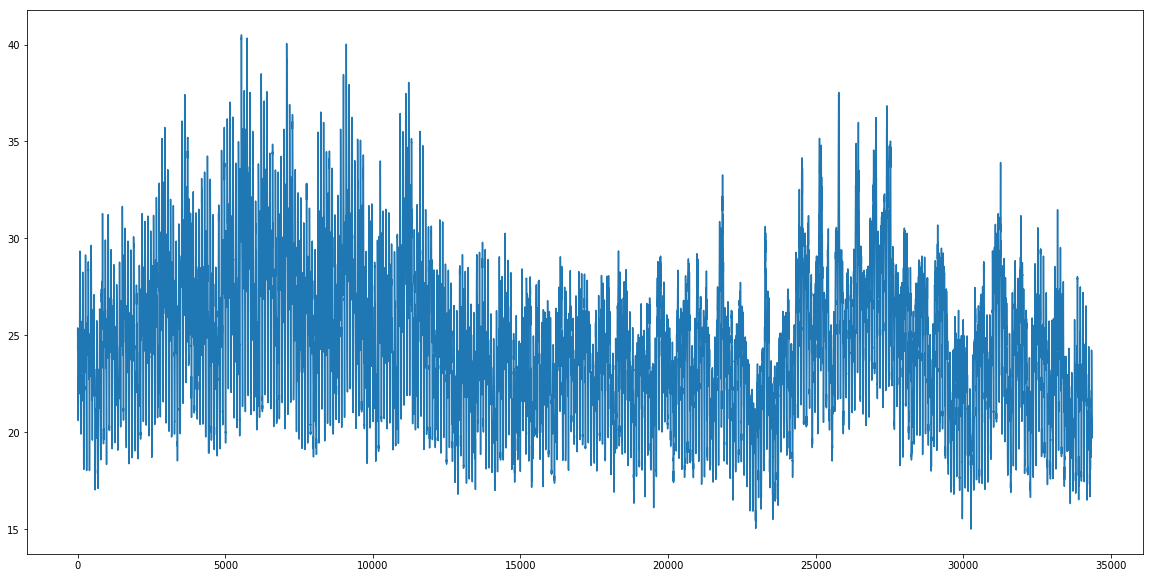

In [14]:
plt.figure(figsize=(20,10))
plt.plot(train_df.VAR)

### Podział datasetu

In [15]:
idx = range(len(train_df))
len(idx)

34368

In [16]:
#from sklearn.utils import resample

In [17]:
dev_last_idx = int(0.8 * len(idx))
#resampled_idx = resample(idx)

In [18]:
dev_idx = idx[:dev_last_idx]
dev_test_idx = idx[dev_last_idx:]

### Zapisanie datasetu

In [19]:
import json

In [20]:
split = {"train": dev_idx,
        "test": dev_test_idx}

In [21]:
with open("data/split_v2", "wb") as f:
    json.dump(split, f)

### Ground truth

In [22]:
columns = df.columns
columns

Index([u'Date', u'VAR', u'dewpti', u'hum', u'pressurei', u'rain', u'tempi',
       u'thunder', u'Day', u'Holiday', u'PCA_1', u'month', u'day', u'hour',
       u'minute'],
      dtype='object')

In [23]:
FEATURES = columns.drop(["Date","VAR"])
GROUND_TRUTH = ["VAR"]

### Baseline - XGBoost

In [24]:
import xgboost as xgb

In [25]:
model = xgb.XGBRegressor()

In [26]:
X_train = df.iloc[dev_idx][FEATURES].values
y_train = df.iloc[dev_idx][GROUND_TRUTH].values.ravel()

In [27]:
X_test = df.iloc[dev_test_idx][FEATURES].values
y_test = df.iloc[dev_test_idx][GROUND_TRUTH].values.ravel()

In [28]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [29]:
y_pred = model.predict(X_test)

### RMSE

In [30]:
rmse = np.sqrt(((y_test - y_pred)**2).mean())
rmse

2.5058095135385563

### MAE

In [31]:
mae = np.abs(y_test - y_pred).mean()
mae

2.10490069802012

### R<sup>2</sup>

In [39]:
y_mean = y_test.mean()
ss_residual = ((y_test - y_pred)**2).sum()
ss_total = ((y_test - y_mean)**2).sum()
R2 = 1 - (ss_residual / ss_total)
R2

0.4248964663620386

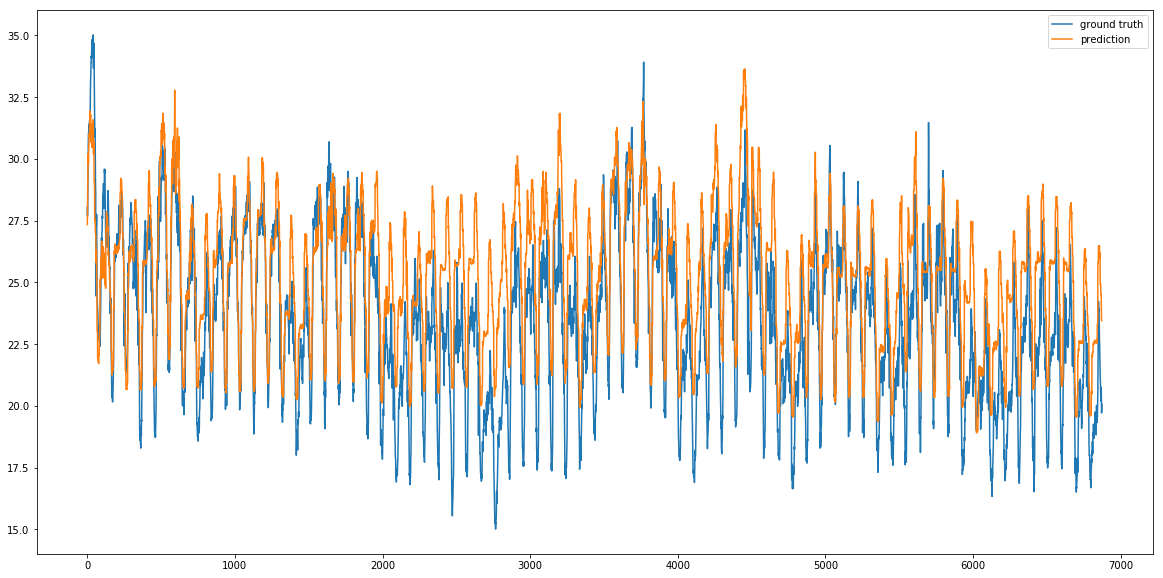

In [40]:
plt.figure(figsize=(20,10))
plt.plot(y_test, label="ground truth")
plt.plot(y_pred, label="prediction")
plt.legend()
plt.savefig("output/xgb_split_v2.png",  bbox_inches='tight')

### Wynik

In [ ]:
X_holdout = test_df[FEATURES].values
y_holdout_pred  = model.predict(X_holdout)
y_holdout_dates = test_df.Date
pd.DataFrame({"Date": y_holdout_dates, "VAR": y_holdout_pred}).to_csv(
    os.path.join(SUBMISSIONS, "baseline_xgb_v2.csv"), index=None)